# Montu Python 
## Astronomical ephemerides for the Ancient World
## Example: Compute *Montunctions* and Aldebaran conjunctions simplified


### Goals of this notebook

### Loading tools

We need to load the packages and the required data for it (star database, planet position database, etc.):

In [11]:
# Montu packages and data
import montu
from montu import D2H, PRINTDF, TABLEDF, DEG, RAD

# Other libraries required
import pandas as pd
import copy
import matplotlib.pyplot as plt
import numpy as np
import datetime

# Load allstars
allstars = montu.Stars()

# These magic commands are intended to allow updating the packages if they change
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### *Marstices*

In [9]:
Tebas = montu.Observer(lon=33,lat=24,height=0)
mars = montu.Planet('Mars')

##############################################
# MARSTICES
##############################################
print("Finding marstices...")
marstices = pd.DataFrame()
i = 0

# Range of years
initial_year = -2500
final_year = -300

mars.reset_store()
mtime = montu.Time(f'{initial_year}-01-01 00:00:00.00',scale='utc',calendar='proleptic')

marstices = []
for _ in montu.WHILE_TRUE():
    jed1,jed2 = mars.next_planesticies(mtime)
    mtime1 = montu.Time(jed1,format='jd',full=True)
    mtime2 = montu.Time(jed2,format='jd',full=True)
    
    # Stopping condition
    if mtime2.readable.year > final_year:
        break
    
    marstices += [pd.DataFrame(dict(
        datepro = [mtime1.readable.datepro,mtime2.readable.datepro],
        datemix = [mtime1.readable.datemix,mtime2.readable.datemix],
        type = ['first','second'],
        jed = [mtime1.jed,mtime2.jed],
    ))]

    mtime = mtime + 2*montu.YEAR
    i += 1

marstices = pd.concat(marstices)
marstices.drop_duplicates(inplace=True)
marstices.reset_index(drop=True,inplace=True)

##############################################
# MARS EPHEMERIS
##############################################
print("Computing Mars ephemeris...")
mars.reset_store()
for index in montu.PROGRESS(marstices.index):
    marstice = marstices.loc[index]

    # Get MonTime object
    mtime = montu.Time(marstice.jed,format='jd')

    # Calculate Mars position and store it
    mars.conditions_in_sky(mtime,Tebas,store=1)
mars.tabulate_store()

mars_marstices = copy.deepcopy(mars.position)
mars_marstices['Vmag'] = mars.condition.Vmag

##############################################
# WINTER SOLSTICES
##############################################
print("Finding winter solstices...")
# Loop on marstices
for index in montu.PROGRESS(marstices.index):
    marstice = marstices.loc[index]

    # Get MonTime object
    mtime = montu.Time(marstice.jed,format='jd')

    # Calculate next and previous solstices
    prev_seasons = montu.Sun.previous_seasons(at=mtime)
    next_seasons = montu.Sun.next_seasons(at=mtime)
    
    # Get the closest solstice
    closest_solstice = min(abs(mtime.jed - prev_seasons[3]),
                           abs(mtime.jed - next_seasons[3]))

    # Add winter solstice to DataFrame
    marstices.loc[index,'closest_solstice'] = closest_solstice

##############################################
# ALDEBARAN
##############################################
print("Computing Aldebaran angular distances...")
aldebaran = allstars.get_stars(ProperName='Aldebaran')

# Loop on marstices
for index in montu.PROGRESS(marstices.index):

    # Get marstice information and location of mars
    marstice = marstices.loc[index]
    mars_location = mars_marstices.loc[index]

    # Propagate aldebaran to epoch
    mtime = montu.Time(marstice.jed,format='jd')
    aldebaran.where_in_space(at=mtime,inplace=True)

    # Compute angular distance
    aldebaran_angdist = montu.Util.haversine_distance(
        mars_location.DecJ2000*DEG,15*mars_location.RAJ2000*DEG,
        float(aldebaran.data.DecJ2000t)*DEG,15*float(aldebaran.data.RAJ2000t)*DEG
    )*RAD    

    # Angular distance
    marstices.loc[index,'aldebaran_angdist'] = aldebaran_angdist

##############################################
# MARK EVENTS
##############################################
print("Marking events...")
max_days_to_solstice = 15 # days
max_aldebaran_angdist = 15 # degrees
max_aldebaran_conjunc = 5 # degrees

marstices['close_solstice'] = False
marstices['close_aldebaran'] = False
marstices['conj_aldebaran'] = False
marstices['montunctions'] = False

cond_solstices = (marstices['closest_solstice']<=max_days_to_solstice)
marstices.loc[cond_solstices,'close_solstice'] = True
print("Number of marstices close to solstices: ",cond_solstices.sum())

cond_aldebaran = (marstices['aldebaran_angdist']<=max_aldebaran_angdist)
marstices.loc[cond_aldebaran,'close_aldebaran'] = True
print("Number of marstices close to Aldebaran: ",cond_aldebaran.sum())

cond_montunctions = (cond_solstices) & (cond_aldebaran)
marstices.loc[cond_montunctions,'montunctions'] = True
print("Number of Montunctions: ",cond_montunctions.sum())

cond_conjunction = (marstices['aldebaran_angdist']<=max_aldebaran_conjunc)
marstices.loc[cond_conjunction,'conj_aldebaran'] = True
print("Number of close conjunctions: ",cond_conjunction.sum())

montunctions = marstices.loc[marstices.montunctions]

Finding marstices...


0it [00:00, ?it/s]

1101it [00:00, 1907.20it/s]


Computing Mars ephemeris...


100%|██████████| 2062/2062 [00:01<00:00, 1554.32it/s]


Finding winter solstices...


100%|██████████| 2062/2062 [00:02<00:00, 915.80it/s]


Computing Aldebaran angular distances...


100%|██████████| 2062/2062 [00:02<00:00, 826.95it/s]

Marking events...
Number of marstices close to solstices:  214
Number of marstices close to Aldebaran:  177
Number of Montunctions:  30
Number of close conjunctions:  23


### Lines chart of marstices and montunctions

In [34]:
jed_min,jed

807125.1627443598

In [39]:
jeds = np.array([[jed_min + i*delta_jed, jed_min + (i+1)*delta_jed] for i in range(npanels)])
jeds

array([[ 807125.16274436,  941433.75647251],
       [ 941433.75647251, 1075742.35020066],
       [1075742.35020066, 1210050.94392881],
       [1210050.94392881, 1344359.53765696],
       [1344359.53765696, 1478668.1313851 ],
       [1478668.1313851 , 1612976.72511325]])

In [37]:
j1 = montu.Time('-700-01-01').jed
j2 = montu.Time('-650-01-01').jed
j1

1465390.5000001

In [41]:
# Get panel
i = int(np.floor((j1 - jed_min)/delta_jed))
i

4

In [38]:
j1-jeds

TypeError: unsupported operand type(s) for -: 'float' and 'list'

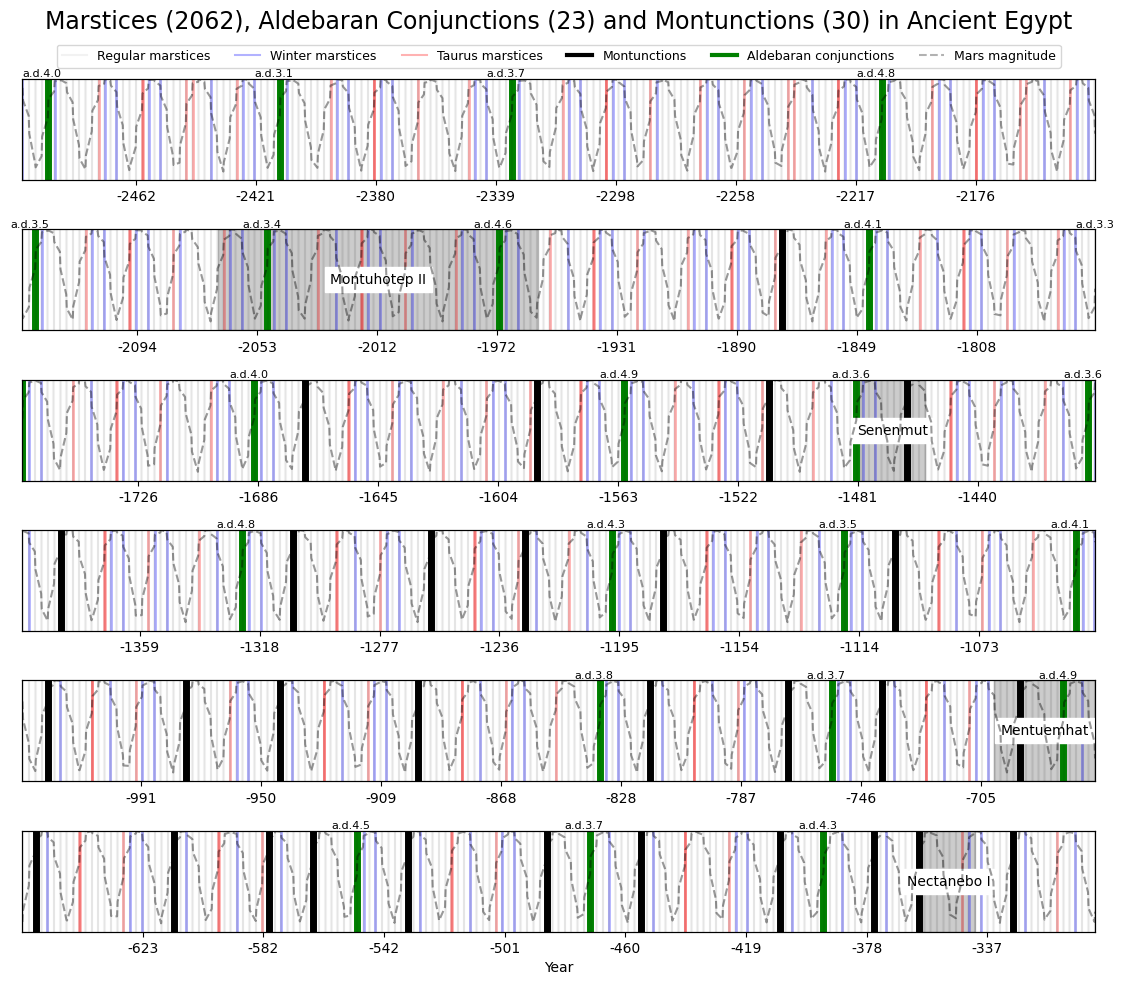

In [16]:
# Selection of marstices
selection = marstices.loc[:]
nmarstices = len(selection)

jed_min = (1-1e-3)*selection.jed.min()
jed_max = (1+1e-3)*selection.jed.max()

# Number of panels
npanels = 6
delta_jed = (jed_max - jed_min)/npanels


fig,axs = plt.subplots(npanels,1,figsize=(12,10))

axts = []
for ax in axs:
    axts += [ax.twinx()]

alpha_marst = 0.05
alpha_wmarst = 0.3
alpha_aldeb = 0.3
alpha_montu = 1
alpha_mag = 0.3

# Loop on marstices
for index in selection.index:

    # Get marstice information and location of mars
    marstice = selection.loc[index]
    mars_location = mars_marstices.loc[index]

    # Get MonTime object
    mtime = montu.Time(marstice.jed,format='jd')

    # Get panel
    i = int(np.floor((mtime.jed - jed_min)/delta_jed))
    
    # Plot line for marstices
    axs[i].axvline(mtime.jed,color='k',alpha=alpha_marst)

    # Plot line for winter marstices
    if marstice.close_solstice:
        axs[i].axvline(mtime.jed,color='b',lw=2,alpha=alpha_wmarst)

    # Plot line for aldebaran conjunctions
    if marstice.close_aldebaran:
        axs[i].axvline(mtime.jed,color='r',lw=2,alpha=alpha_aldeb)

    # Plot line for aldebaran close conjunctions
    if marstice.conj_aldebaran:
        axs[i].axvline(mtime.jed,color='g',lw=5,alpha=alpha_montu)
        
    # Plot line for montunctions
    if marstice.close_solstice and marstice.close_aldebaran:
        axs[i].axvline(mtime.jed,color='k',lw=5,alpha=alpha_montu)

# Plot distance
for i,axt in enumerate(axts):
    jed_ax_min = jed_min + i*delta_jed
    jed_ax_max = jed_ax_min + delta_jed
    cond = (marstices.jed>=jed_ax_min)&(marstices.jed<=jed_ax_max)
    #axt.plot(marstices[cond].jed,mars.df[cond].site_distance,'k',alpha=0.4)
    axt.plot(marstices[cond].jed,mars_marstices[cond].Vmag,'k--',alpha=0.4)
    
# Loop on marstices
for index in selection.index:
    # Get MonTime object
    mtime = montu.Time(marstice.jed,format='jd')

    # Get marstice information and location of mars
    marstice = selection.loc[index]
    
    # Get panel
    i = int(np.floor((mtime.jed - jed_min)/delta_jed))
    
    # Plot line for aldebaran close conjunctions
    if marstice.conj_aldebaran:
        mmin,mmax = axts[i].get_ylim()
        t = axts[i].text(mtime.jed,0.95*mmax,f"a.d.{marstice.aldebaran_angdist:.1f}",
                         ha='center',va='center',fontsize=8)

# Decoration
for i,ax in enumerate(axs):
    ax.margins(0)
    ax.get_yaxis().set_visible(False)
    jed_ax_min = jed_min + i*delta_jed
    jed_ax_max = jed_ax_min + delta_jed
    ax.set_xticks(np.linspace(jed_ax_min,jed_ax_max,10))
    
# Change xticks
for ax in axs:
    xticks = ax.get_xticks()
    xtick_labels = []
    for xt in xticks:
        mtime = montu.Time(xt,format='jd',full=True)
        xtick_labels += [f'{mtime.readable.year}']
    ax.set_xticklabels(xtick_labels)

for ax in axts:
    ax.margins(0)
    ax.set_yticks(np.arange(-2.5,0.0,0.5))
    ax.get_yaxis().set_visible(False)

# Legends 
axs[0].plot([],[],'k-',alpha=alpha_marst,label='Regular marstices')
axs[0].plot([],[],'b-',alpha=alpha_wmarst,label='Winter marstices')
axs[0].plot([],[],'r-',alpha=alpha_aldeb,label='Taurus marstices')
axs[0].plot([],[],'k-',alpha=alpha_montu,lw=3,label='Montunctions')
axs[0].plot([],[],'g-',alpha=alpha_montu,lw=3,label='Aldebaran conjunctions')
axs[0].plot([],[],'k--',alpha=alpha_mag,label='Mars magnitude')
axs[0].legend(bbox_to_anchor=(0.5,1.4),ncol=6,fontsize=9,loc='upper center')

# Other decoration
axs[-1].set_xlabel('Year')

axs[0].text(0.5,1.5,f"Marstices ({len(marstices)}), Aldebaran Conjunctions ({selection.conj_aldebaran.sum()}) and Montunctions ({len(montunctions)}) in Ancient Egypt",
            transform=axs[0].transAxes,fontsize=17,ha='center')

# Montuhotep II 
iax = 1
j1 = montu.Time('-2066-01-01').jed
j2 = montu.Time('-1957-01-01').jed
jk = (j1+j2)/2
mmin,mmax = axs[iax].get_ylim()
axs[iax].axvspan(j1,j2,color='k',alpha=0.2)
t = axs[iax].text(jk,0.0,'Montuhotep II',ha='center',va='center',fontsize=10)
t.set_bbox(dict(facecolor='white', edgecolor='white'))

# Senenmut
iax = 2
j1 = montu.Time('-1480-01-01').jed
j2 = montu.Time('-1458-01-01').jed
jmin,jmax = axs[iax].get_xlim()
j1 = max(j1,jmin)
j2 = min(j2,jmax)
jk = (j1+j2)/2
mmin,mmax = axs[iax].get_ylim()
axs[iax].axvspan(j1,j2,color='k',alpha=0.2)
t = axs[iax].text(jk,0.0,'Senenmut',ha='center',va='center',fontsize=10)
t.set_bbox(dict(facecolor='white', edgecolor='white'))

# Mentuemhat
iax = 4
j1 = montu.Time('-700-01-01').jed
j2 = montu.Time('-650-01-01').jed
jmin,jmax = axs[iax].get_xlim()
j1 = max(j1,jmin)
j2 = min(j2,jmax)
jk = (j1+j2)/2
mmin,mmax = axs[iax].get_ylim()
axs[iax].axvspan(j1,j2,color='k',alpha=0.2)
t = axs[iax].text(jk,0.0,'Mentuemhat',ha='center',va='center',fontsize=10)
t.set_bbox(dict(facecolor='white', edgecolor='white'))

# Senenmut
iax = 5
j1 = montu.Time('-359-01-01').jed
j2 = montu.Time('-341-01-01').jed
jmin,jmax = axs[iax].get_xlim()
j1 = max(j1,jmin)
j2 = min(j2,jmax)
jk = (j1+j2)/2
mmin,mmax = axs[iax].get_ylim()
axs[iax].axvspan(j1,j2,color='k',alpha=0.2)
t = axs[iax].text(jk,0.0,'Nectanebo I',ha='center',va='center',fontsize=10)
t.set_bbox(dict(facecolor='white', edgecolor='white'))

fig.tight_layout()

## Selected events

In [29]:
#date = 'bce2050-01-01';deltat = 10*montu.YEAR # Mentuhotep II
#date = 'bce1460-01-01';deltat = 10*montu.YEAR # Senenmut
#date = 'bce660-01-01';deltat = 50*montu.YEAR # Senenmut
date = 'bce359-01-01';deltat = 50*montu.YEAR # Mentuhotep II

mtime = montu.Time(date)
mtime_start = mtime-deltat
mtime_end = mtime+deltat

cond = (marstices.jed>=mtime_start.jed) & (marstices.jed<=mtime_end.jed) & (marstices.conj_aldebaran)
print("Number of Aldebaran conjunctions in the desired interval: ",cond.sum())
marstices_selected = marstices.loc[cond]
montu.PRINTDF(marstices_selected)

cond = (montunctions.jed>=mtime_start.jed) & (montunctions.jed<=mtime_end.jed)
print("Number of montunctions in the desired interval: ",cond.sum())
montunctions_selected = montunctions.loc[cond]
montu.PRINTDF(montunctions_selected)


Number of Aldebaran conjunctions in the desired interval:  1


,datepro,datemix,type,jed,closest_solstice,aldebaran_angdist,close_solstice,close_aldebaran,conj_aldebaran,montunctions
1974,-0393-09-14 00:42:05.3000,-393-09-19 00:42:42,first,1.577776e+06,98.235818,4.317869,False,True,True,False


Number of montunctions in the desired interval:  4


,datepro,datemix,type,jed,closest_solstice,aldebaran_angdist,close_solstice,close_aldebaran,conj_aldebaran,montunctions
1961,-0408-12-14 06:13:49.0000,-408-12-19 06:13:13,second,1.572389e+06,6.360604,7.812448,True,True,False,True
1991,-0376-12-23 21:54:05.8000,-376-12-28 21:54:54,second,1.584086e+06,3.510291,12.573222,True,True,False,True
2005,-0361-12-07 13:29:12.8000,-361-12-12 13:29:29,second,1.589548e+06,13.487548,9.511924,True,True,False,True
2035,-0329-12-17 16:20:14.6000,-329-12-22 16:20:20,second,1.601246e+06,3.143461,8.413307,True,True,False,True
